**Importing the libraries.**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

import yfinance as yf
yf.pdr_override()

**Importing the data.**

In [2]:
#Loading data using Pandas Datareader
company = 'TSLA'

start = dt.datetime(2013,9,8)
end = dt.datetime(2022,9,8)
#Loading Tesla stock data from Yahoo Finance
data = pdr.get_data_yahoo(company, start, end)

[*********************100%%**********************]  1 of 1 completed


In [3]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-09-09,10.874667,10.966667,10.567333,10.713333,10.713333,215167500
2013-09-10,10.763333,11.166667,10.708667,11.091333,11.091333,134517000
2013-09-11,11.094000,11.193333,10.808667,10.901333,10.901333,87487500
2013-09-12,10.933333,11.117333,10.700667,10.995333,10.995333,92400000
2013-09-13,10.851333,11.091333,10.810667,11.036000,11.036000,81018000
...,...,...,...,...,...,...
2022-08-31,280.619995,281.250000,271.809998,275.609985,275.609985,52107300
2022-09-01,272.579987,277.579987,266.149994,277.160004,277.160004,54287000
2022-09-02,281.070007,282.350006,269.079987,270.209991,270.209991,50890100


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2266 entries, 2013-09-09 to 2022-09-07
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2266 non-null   float64
 1   High       2266 non-null   float64
 2   Low        2266 non-null   float64
 3   Close      2266 non-null   float64
 4   Adj Close  2266 non-null   float64
 5   Volume     2266 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 123.9 KB


2266 entries in total.

The closing price is the last price at which the stock is traded during the regular trading day. A stock’s closing price is the standard benchmark used by investors to track its performance over time.

While the closing price simply refers to the cost of shares at the end of the day, the adjusted closing price takes dividends, stock splits, and new stock offerings into account. The adjusted closing price is a more accurate indicator of stock value since it starts where the closing price finishes.

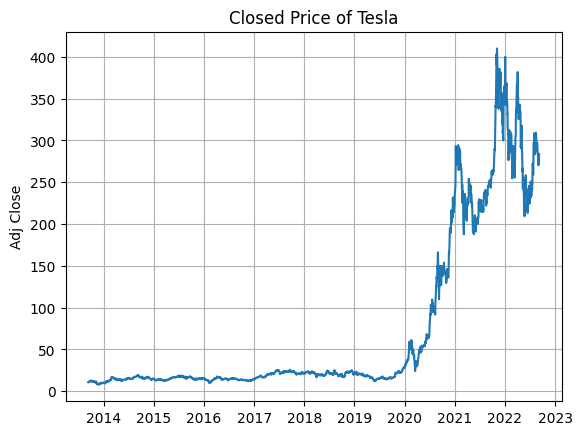

In [5]:
plt.plot(data['Adj Close'])
plt.xlabel(None)
plt.ylabel('Adj Close')
plt.title('Closed Price of Tesla')
plt.grid(True)
plt.show()

**Preparing the data.**

In [6]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Adj Close'].values.reshape(-1,1))

In [7]:
scaled_data

array([[0.00666772],
       [0.00760817],
       [0.00713545],
       ...,
       [0.6522835 ],
       [0.66275785],
       [0.68584606]])

**Setting window size of 60 and creating the training data set.**

Neural networks, including LSTMs, typically expect input data in the form of NumPy arrays, as they are more efficient for mathematical operations.

In LSTM models for time series forecasting, the input data should have 3-dimensional shape with following format:
The three-dimensional shape (number_of_samples, number_of_time_steps, number_of_features) is a common format for LSTM input data.

Number of samples (or data points): This is given by the first dimension of x_train, represented as x_train.shape[0].

Number of time steps: This is given by the second dimension of x_train, represented as x_train.shape[1].

Number of features (in this case, it's set to 1): The third dimension is used to represent the number of features. In time series forecasting, you typically have one feature (e.g., historical stock prices), so it's set to 1.

In [8]:
prediction_days = 60
X_train = []
Y_train = []

for i in range(prediction_days, len(scaled_data)):
   X_train.append(scaled_data[i-prediction_days:i, 0])
   Y_train.append(scaled_data[i,0])

# Converting to numpy arrays.
X_train, Y_train = np.array(X_train), np.array(Y_train)

#This reshapes the X_train NumPy array to have a three-dimensional shape.
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1) )

In [9]:
X_train.shape

(2206, 60, 1)

2206 total data entries with 60 entries taken at a time.

**Creating the LSTM model.**


In [10]:
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1)) #Prediction of next closing value


**Training the model**

In [11]:
model.compile(optimizer='adam',loss='mean_squared_error')


In [12]:
model.fit(X_train,Y_train,epochs=25,batch_size=32)

Epoch 1/25
69/69 [==============================] - 18s 135ms/step - loss: 0.0072
Epoch 2/25
69/69 [==============================] - 10s 147ms/step - loss: 0.0034
Epoch 3/25
69/69 [==============================] - 10s 147ms/step - loss: 0.0028
Epoch 4/25
69/69 [==============================] - 10s 141ms/step - loss: 0.0024
Epoch 5/25
69/69 [==============================] - 9s 130ms/step - loss: 0.0024
Epoch 6/25
69/69 [==============================] - 12s 172ms/step - loss: 0.0019
Epoch 7/25
69/69 [==============================] - 10s 146ms/step - loss: 0.0023
Epoch 8/25
69/69 [==============================] - 10s 146ms/step - loss: 0.0019
Epoch 9/25
69/69 [==============================] - 9s 127ms/step - loss: 0.0018
Epoch 10/25
69/69 [==============================] - 10s 147ms/step - loss: 0.0017
Epoch 11/25
69/69 [==============================] - 10s 149ms/step - loss: 0.0015
Epoch 12/25
69/69 [==============================] - 10s 147ms/step - loss: 0.0016
Epoch 13/25
69/

## **Testing model accuracy on existing data**

**Load Test Data**

In [13]:
test_start = dt.datetime(2022,9,8)
test_end = dt.datetime.now()

test_data = pdr.get_data_yahoo(company, test_start, test_end)

[*********************100%%**********************]  1 of 1 completed


In [14]:
test_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-09-08,281.299988,289.500000,279.760010,289.260010,289.260010,53713100
2022-09-09,291.670013,299.850006,291.250000,299.679993,299.679993,54338100
2022-09-12,300.720001,305.489990,300.399994,304.420013,304.420013,48674600
2022-09-13,292.899994,297.399994,290.399994,292.130005,292.130005,68229600
2022-09-14,292.239990,306.000000,291.640015,302.609985,302.609985,72628700
...,...,...,...,...,...,...
2023-08-31,255.979996,261.179993,255.050003,258.079987,258.079987,108861700
2023-09-01,257.260010,259.079987,242.009995,245.009995,245.009995,132272500
2023-09-05,245.000000,258.000000,244.860001,256.489990,256.489990,129469600


**Preparing the data and creating test dataset**

In [15]:
actual_prices = test_data['Adj Close'].values

total_dataset = pd.concat((data['Adj Close'],test_data['Adj Close']),axis=0)

inputs = total_dataset[len(total_dataset)-len(test_data)-prediction_days:].values.reshape(-1,1)
inputs = scaler.transform(inputs)

X_test=[]

for i in range(prediction_days, len(inputs)):
   X_test.append(inputs[i-prediction_days:i, 0])

X_test= np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1) )



**Training model on test data**

In [16]:
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices)


8/8 [==============================] - 3s 40ms/step


**Plotting the test prediction**

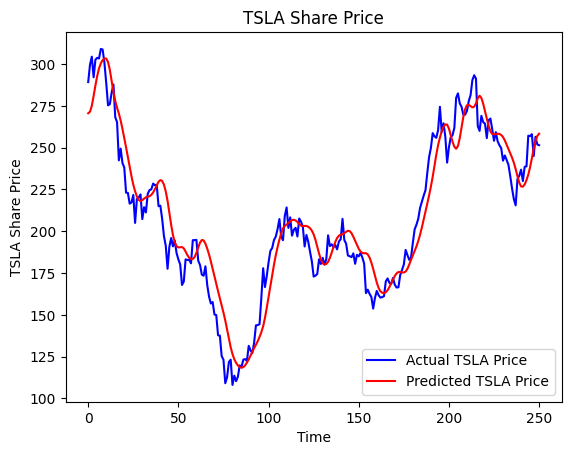

In [17]:
plt.plot(actual_prices,color='b',label=f"Actual {company} Price")
plt.plot(predicted_prices, color='r',label=f"Predicted {company} Price")
plt.title(f"{company} Share Price")
plt.xlabel('Time')
plt.ylabel(f'{company} Share Price')
plt.legend()
plt.show()

## **Predicting the next day**

**Creating dataset with next day (day to predict) included**

In [36]:
# Get the most recent 'prediction_days' data points from 'inputs' as input for prediction
prediction_input = inputs[-prediction_days:]
prediction_input = np.array(prediction_input)

# Reshape the input data to match the model's input shape (samples, time steps, features)
prediction_input = np.reshape(prediction_input, (1, prediction_days, 1))

**Training model on dataset**

In [37]:
prediction = model.predict(prediction_input)
prediction = scaler.inverse_transform(prediction)
print(f"Predicted value for the next day: {prediction}")

1/1 [==============================] - 0s 38ms/step
Predicted value for the next day: [[258.2823]]


**Predicting increase or decrease**

In [49]:
last_row = test_data.iloc[-1]
# Obtain the adjusted closing price of today
curr_adj_close_price = last_row['Adj Close']

if curr_adj_close_price < prediction :
  print("Increase")

else:
  print("Decrease")




Increase
